In [1]:
import keras
import numpy as np

from keras.models import Sequential

/Applications/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Sentiment Classification

In this problem we will use Kera's imdb sentiment dataset. You will take in sequences of words and use an RNN to try to classify the sequences sentiment. These sentences are movie reviews, so the sentiment reflects whether its a positive review (sentiment of 1) or a negative review (sentiment of 0). 

First we have to process the data a little bit, so that we have fixed length sequences.

The data is given to us in integer form, so each integer represents a unique word, 0 represents a PAD character, 1 represents a START character and 2 represents a character that is unknown because it is not in the top `num_words`. 
Thus 3 represents the first real word. 

Also the words are in decreasing order of commonness, so the word that 3 represents is the most common word in the dataset. (It happens to be `the`)

In [2]:
from keras.datasets import imdb
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=1000, maxlen=200, index_from=3)

#### We want to process the data into arrays of sequences that are all length 200. If a given sequence is shorter than 200 tokens we want to pad the rest of the sequence out with zeros so that the sequence is 200 long.

In [3]:
def process_data(data):
    processed = np.zeros(len(data) * 200).reshape((len(data), 200))
    for i, seq in enumerate(data):
        if len(seq) < 200:
            processed[i] = np.pad(seq, (0,200-len(seq)), 'constant') # PAD SEQUENCES WITH ZEROS HERE
        else:
            processed[i] = np.array(seq)
    return processed

In [4]:
x_train_proc = process_data(x_train)
x_test_proc = process_data(x_test)

In [5]:
imdb_model = Sequential()

Now we want to add an embedding layer. The purpose of an embedding layer is to take a sequence of integers representing words in our case and turn each integer into a dense vector in some embedding space. (This is essentially the idea of Word2Vec). We want to create an embedding layer with vocab size equal to the max num words we allowed when we loaded the data (in this case 1000), and a fixed dense vector of size 32. Then we have to specify the max length of our sequences and we want to mask out zeros in our sequence since we used zero to pad.
Use the docs for embedding layer to fill out the missing entries: https://keras.io/layers/embeddings/

In [6]:
from keras.layers.embeddings import Embedding
imdb_model.add(Embedding(1000, 32, input_length=200, mask_zero=True))

#### **(a)** Add an LSTM layer with 32 outputs, then a Dense layer with 16 neurons, then a relu activation, then a dense layer with 1 neuron, then a sigmoid activation. Then you should print out the model summary. The Keras documentation is here: https://keras.io/

In [7]:
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Activation
imdb_model.add(LSTM(32))

In [8]:
imdb_model.add(Dense(16))
imdb_model.add(Activation('relu'))

In [9]:
imdb_model.add(Dense(1))
imdb_model.add(Activation('sigmoid'))

In [10]:
imdb_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 32)           32000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
activation_1 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 40,865
Trainable params: 40,865
Non-trainable params: 0
_________________________________________________________________


### If you did the above parts correctly running `imdb_model.summary()` should give you the following output.

In [11]:
#from IPython.display import Image
#Image(filename='/home/james/Desktop/Screenshot from 2018-08-20 21-04-15.png')

#### **(b)** Now compile the model with binary cross entropy, and the adam optimizer. Also include accuracy as a metric in the compile. Then train the model on the processed data (no need to worry about class weights this time)

In [12]:
imdb_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
imdb_model.fit(x_train_proc, y_train)

Epoch 1/1
25000/25000 [==============================] - 207s 8ms/step - loss: 0.4000 - acc: 0.8144


In [14]:
print("Accuracy: ", imdb_model.evaluate(x_test_proc, y_test)[1])

3913/3913 [==============================] - 8s 2ms/step
Accuracy:  0.8428315870480985


#### Now we can look at our predictions and the sentences they correspond to.

In [15]:
y_pred = imdb_model.predict(x_test_proc)

In [16]:
word_to_id = keras.datasets.imdb.get_word_index()
word_to_id = {k:(v+3) for k,v in word_to_id.items()}
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<UNK>"] = 2

id_to_word = {value:key for key,value in word_to_id.items() if value < 1000}
def get_words(token_sequence):
    return ' '.join(id_to_word[token] for token in token_sequence)

def get_sentiment(y_pred, index):
    return 'Positive' if y_pred[index] else 'Negative'

In [17]:
y_pred = np.vectorize(lambda x: int(x >= 0.5))(y_pred)
correct = []
incorrect = []
for i, pred in enumerate(y_pred):
    if y_test[i] == pred:
        correct.append(i)
    else:
        incorrect.append(i)

#### Now we print out one of the sequences we got correct.

In [18]:
print(get_sentiment(y_pred, correct[10]))
print(get_words(x_test[correct[10]]))

Negative
<START> don't tell me this film was funny or a little funny it was a complete <UNK> and one of the worst movies i've ever seen <UNK> <UNK> is only funny on <UNK> <UNK> <UNK> <UNK> show after watching his performance all i can say is he is not made for movies with a <UNK> script or more like no storyline there's nothing to keep you <UNK> full of annoying <UNK> <UNK> this movie is a complete <UNK> all the way at the end of the film <UNK> <UNK> gives a <UNK> he <UNK> if you <UNK> this film tell people it was good not even the <UNK> could save the movie he probably knew its <UNK> be a <UNK> i would of given this a <UNK> 10 but the <UNK> start is 1 overall don't even waste your time on this <UNK>


#### And one we got wrong.

In [19]:
print(get_sentiment(y_pred, incorrect[10]))
print(get_words(x_test[incorrect[10]]))

Negative
<START> this is the only thing i will be able to look back on from the year <UNK> and say now that <UNK> it <UNK> hard and yet it also <UNK> <UNK> mr <UNK> <UNK> a nice little <UNK> to this <UNK> of a film before the opening credits even <UNK> now that tells you something this filmed <UNK> even before it started now i don't want to give to much away or be a <UNK> but this movie <UNK> if you have heard the new <UNK> and thought to yourself this seems a bit <UNK> <UNK> material it is like i a <UNK> playing <UNK> with <UNK> what gives then this movie will <UNK> your <UNK> for the music and you will <UNK> at this <UNK> <UNK> masterpiece for those who would want it better do not know what they want because better would no <UNK> be the <UNK> this movie is the <UNK> period so <UNK> if you <UNK> to the local viewing theater if you to want to have your <UNK> <UNK>


#### As you can see the amount of UNKNOWN characters in the sequence cause by having only 1000 vocab words is hurting our performance. See if you can go through and increase the number of vocab words to 2000. HINT: you have to change two places in the above code.

In [20]:
from keras import backend as K

## Embedding Exploration
#### Another interesting thing to do is see if our learned embeddings mean anything reasonable.

In [21]:
# this function takes a list of token sequences as inputs 
# and outputs the corresponding vector outputs of our `Embedding` layer
embedding_func = K.function([imdb_model.inputs[0]], [imdb_model.layers[0].output])

In [22]:
# this function outputs the embedding of a given word using above function
def word_to_embedding(word):
    token = word_to_id[word]
    seq = [token]
    sequences = [seq]
    inputs = [process_data(sequences)]
    embedding = embedding_func(inputs)
    return embedding[0][0][0]

In [23]:
valid_words = [word for word, token in word_to_id.items() if token < 1000]

In [24]:
valid_word_embeddings = {word: word_to_embedding(word) for word in valid_words}

Since we used an embedding layer with an output size of 32, our embeddings are going to be 32-dimensional vectors. Humans can't effectively visualize beyond 3 (maybe 4) dimensions so we want to use a dimensionality reduction technique to make our embeddings more visualizable. One such technique is Principal Component Analysis or PCA. The library scikit-learn provides an easy to use API for this technique.

In [25]:
import sklearn
from sklearn import decomposition

#### using the documentation for scikit-learn's PCA [here](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html): create a PCA object with `n_components=2`

In [26]:
pca = decomposition.PCA(n_components=2)

#### using the same documentation find the function to fit the PCA transform to the provided embedding vectors. This step essentially. For the curious, this step essentially finds the 2 dimensions (since we specified `n_components=2` that explain the most variance of the dataset, in other words the two dimensions that are most representative of the deviations of any one sample to another. So these 2 dimensions are the most important and therefore the best to visualize.

In [27]:
vectors_to_fit = valid_word_embeddings.values()
pca.fit(list(vectors_to_fit))

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

#### Now we want to visualize our embeddings in these new PCA dimensions, so using the same documentation from above fill out the missing spots in the code below to transform the embeddings into the pca dimensions.

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
def get_pca_words(words):
    embeddings = [valid_word_embeddings[word] for word in words]
    pcas = [pca.transform(embedding.reshape(1, -1)) for embedding in embeddings]
    return pcas

def plot_pca_words(words, scale=1):
    pcas = get_pca_words(words)
    zeros = [0 for _ in pcas]
    x_start = zeros
    y_start = zeros
    xs = [p[0, 0] for p in pcas]
    ys = [p[0, 1] for p in pcas]
    plt.quiver(x_start, y_start, xs, ys, scale=scale)
    plt.show()

#### Now using the above functions we can plot the corresponding pca vectors of any words we like. Below are some good examples of pairs of words that are similar within the movie review context and their corresponding vectors are also similar. **This is a good sign.** This means the embedding we have learned is likely doing something somewhat reasonable.

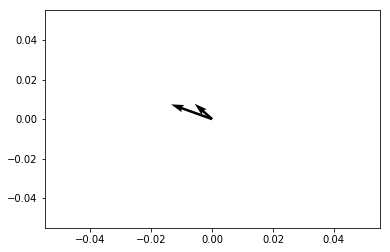

In [29]:
plot_pca_words(['film', 'entertainment'], scale=0.5)

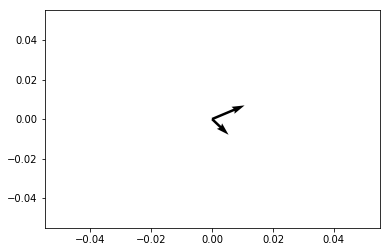

In [30]:
plot_pca_words(['man', 'woman'])

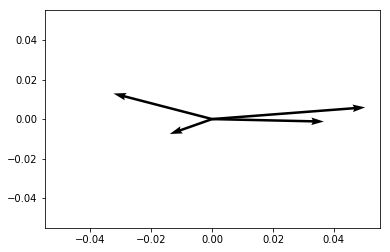

In [31]:
plot_pca_words(['good', 'bad', 'horrible', 'great'], scale=2)

#### Now find 2 more pairs of words that are similar in PCA'd embedding space. 

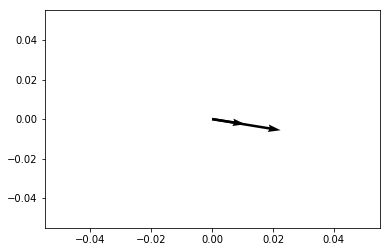

In [32]:
plot_pca_words(['big', 'huge']) # plot pair of similar words here

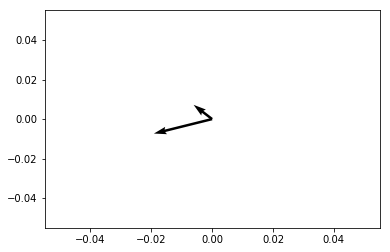

In [33]:
plot_pca_words(['small', 'little']) # plot another pair of similar words here

#### Given that the task we learned these embeddings for was sentiment classification, the embeddings are typically more meaningful for adjectives. Write a sentence or two about why you think this last statement makes sense intuitively.

In [34]:
print("Because adjectives are easier to determine the similarity.") #TODO see above

Because adjectives are easier to determine the similarity.


#### Now just for fun we can write a function that gives us the 10 closest words to a provided word.

In [35]:
def word_to_angle(word):
    p = pca.transform(valid_word_embeddings[word].reshape(-1, 1))
    return np.arctan(p[0, 1] / p[0, 0])
valid_word_angles = [word_to_angle(word) for word in valid_words]

In [36]:
def find_closest_n(value, n):
    indices = np.argsort(np.abs(np.array(valid_word_angles) - value))
    return [(valid_words[ind], valid_word_angles[ind]) for ind in indices[:n]]

In [37]:
find_closest_n(word_to_angle('terrible'), 10)

[('terrible', 0.2170108687573711),
 ('fails', 0.21747084661862479),
 ('awful', 0.21639272793975523),
 ('boring', 0.2154790478983043),
 ('worst', 0.22017389650550412),
 ('worse', 0.21254341846618524),
 ('waste', 0.21240171757318435),
 ('poor', 0.21116998703784204),
 ('poorly', 0.21074813582523938),
 ('cheap', 0.21050379179714995)]